# 图像显著区域检测

In [162]:
#coding:utf-8
import numpy as np
%matplotlib  inline
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from scipy.misc import imread, imresize, imsave
from skimage.filters import threshold_otsu
from skimage.color import rgb2lab
import scipy.spatial.distance
import scipy.signal
import skimage
import skimage.io
from skimage.segmentation import slic
from skimage.util import img_as_float
from scipy.optimize import minimize
import math
import operator
import networkx as nx
import pdb
import itertools

In [141]:
rgb = cv2.cvtColor(cv2.imread('../datas/f3.jpg'),cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(rgb,cv2.COLOR_RGB2GRAY)

In [142]:
def saliency(src):
    height,width,ch = src.shape
    sz = height * width
    lab = rgb2lab(src)
    sl = lab[:,:,0]
    sa = lab[:,:,1]
    sb = lab[:,:,2]
#     avgl = np.sum(sl) / sz
#     avga = np.sum(sa) / sz
#     avgb = np.sum(sb) / sz
    avgl = np.mean(sl)
    avga = np.mean(sa)
    avgb = np.mean(sb)

    salmap = np.zeros((height * width,),dtype=np.float32)
    kernel = (1.0 / 16.0) * np.array([[1,4,6,4,1]])
    sl = cv2.filter2D(sl,-1,kernel)
    sa = cv2.filter2D(sa,-1,kernel)
    sb = cv2.filter2D(sb,-1,kernel)
    sl = cv2.filter2D(sl,-1,kernel.T)
    sa = cv2.filter2D(sa,-1,kernel.T)
    sb = cv2.filter2D(sb,-1,kernel.T)
#     sl = cv2.GaussianBlur(sl,(3,3),0)
#     sa = cv2.GaussianBlur(sa,(3,3),0)
#     sb = cv2.GaussianBlur(sb,(3,3),0)
    
    sl = sl.reshape((sz,)).astype(np.float32)
    sa = sa.reshape((sz,)).astype(np.float32)
    sb = sb.reshape((sz,)).astype(np.float32)
    
    salmap = (sl - avgl) ** 2 + (sa - avga) ** 2 + (sb - avgb) ** 2
    salmap = salmap.reshape((height,width))
    # 归一化
    mri_max = np.amax(salmap)  
    mri_min = np.amin(salmap)  
    salmap = ((salmap-mri_min)/(mri_max-mri_min))*255  
     
    salmap[salmap < 0] = 0
    salmap[salmap > 255] = 255
    return salmap.reshape((height,width)).astype(np.uint8)

In [143]:
dst = saliency(rgb)

True

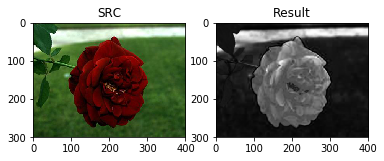

In [144]:
plt.subplot(121)
plt.imshow(rgb)
plt.title('SRC')
plt.subplot(122)
plt.imshow(dst,'gray')
plt.title('Result')
cv2.imwrite('../temp/bird.jpg',dst)

In [145]:
rgb = cv2.cvtColor(cv2.imread('../datas/circle.jpg'),cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(rgb,cv2.COLOR_RGB2GRAY)

Text(0.5,1,'Result')

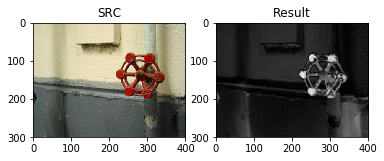

In [146]:
dst = saliency(rgb)
plt.subplot(121)
plt.imshow(rgb)
plt.title('SRC')
plt.subplot(122)
plt.imshow(dst,'gray')
plt.title('Result')

In [147]:
rgb = cv2.cvtColor(cv2.imread('../datas/bird.jpg'),cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(rgb,cv2.COLOR_RGB2GRAY)

Text(0.5,1,'Result')

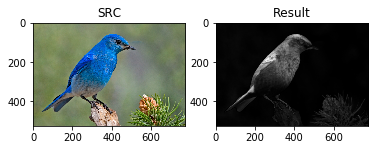

In [148]:
dst = saliency(rgb)
plt.subplot(121)
plt.imshow(rgb)
plt.title('SRC')
plt.subplot(122)
plt.imshow(dst,'gray')
plt.title('Result')

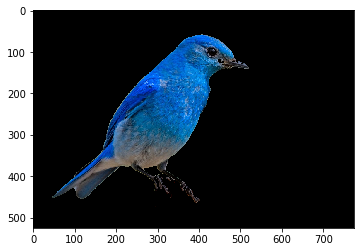

In [167]:
dst_rgb = np.zeros_like(rgb)
idx = dst > 120 
dst_rgb[idx] = rgb[idx]
plt.imshow(dst_rgb)

In [149]:
def make_graph(grid):
	# get unique labels
	vertices = np.unique(grid)
 
	# map unique labels to [1,...,num_labels]
	reverse_dict = dict(zip(vertices,np.arange(len(vertices))))
	grid = np.array([reverse_dict[x] for x in grid.flat]).reshape(grid.shape)
   
	# create edges
	down = np.c_[grid[:-1, :].ravel(), grid[1:, :].ravel()]
	right = np.c_[grid[:, :-1].ravel(), grid[:, 1:].ravel()]
	all_edges = np.vstack([right, down])
	all_edges = all_edges[all_edges[:, 0] != all_edges[:, 1], :]
	all_edges = np.sort(all_edges,axis=1)
	num_vertices = len(vertices)
	edge_hash = all_edges[:,0] + num_vertices * all_edges[:, 1]
	# find unique connections
	edges = np.unique(edge_hash)
	# undo hashing
	edges = [[vertices[x%num_vertices],
			  vertices[x//num_vertices]] for x in edges] 
 
	return vertices, edges

In [150]:
def S(x1,x2,geodesic,sigma_clr=10):
	return math.exp(-pow(geodesic[x1,x2],2)/(2*sigma_clr*sigma_clr))

def compute_saliency_cost(smoothness,w_bg,wCtr):
	n = len(w_bg)
	A = np.zeros((n,n))
	b = np.zeros((n))

	for x in range(0,n):
		A[x,x] = 2 * w_bg[x] + 2 * (wCtr[x])
		b[x] = 2 * wCtr[x]
		for y in range(0,n):
			A[x,x] += 2 * smoothness[x,y]
			A[x,y] -= 2 * smoothness[x,y]
	
	x = np.linalg.solve(A, b)

	return x

def path_length(path,G):
	dist = 0.0
	for i in range(1,len(path)):
		dist += G[path[i - 1]][path[i]]['weight']
	return dist

In [151]:
def get_saliency_rbd(img_path):

	# Saliency map calculation based on:
	# Saliency Optimization from Robust Background Detection, Wangjiang Zhu, Shuang Liang, Yichen Wei and Jian Sun, IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2014

	img = skimage.io.imread(img_path)

	if len(img.shape) != 3: # got a grayscale image
		img = skimage.color.gray2rgb(img)

	img_lab = img_as_float(skimage.color.rgb2lab(img))

	img_rgb = img_as_float(img)

	img_gray = img_as_float(skimage.color.rgb2gray(img))

	segments_slic = slic(img_rgb, n_segments=250, compactness=10, sigma=1, enforce_connectivity=False)

	num_segments = len(np.unique(segments_slic))

	nrows, ncols = segments_slic.shape
	max_dist = math.sqrt(nrows*nrows + ncols*ncols)

	grid = segments_slic

	(vertices,edges) = make_graph(grid)

	gridx, gridy = np.mgrid[:grid.shape[0], :grid.shape[1]]

	centers = dict()
	colors = dict()
	distances = dict()
	boundary = dict()

	for v in vertices:
		centers[v] = [gridy[grid == v].mean(), gridx[grid == v].mean()]
		colors[v] = np.mean(img_lab[grid==v],axis=0)

		x_pix = gridx[grid == v]
		y_pix = gridy[grid == v]

		if np.any(x_pix == 0) or np.any(y_pix == 0) or np.any(x_pix == nrows - 1) or np.any(y_pix == ncols - 1):
			boundary[v] = 1
		else:
			boundary[v] = 0

	G = nx.Graph()

	#buid the graph
	for edge in edges:
		pt1 = edge[0]
		pt2 = edge[1]
		color_distance = scipy.spatial.distance.euclidean(colors[pt1],colors[pt2])
		G.add_edge(pt1, pt2, weight=color_distance )

	#add a new edge in graph if edges are both on boundary
	for v1 in vertices:
		if boundary[v1] == 1:
			for v2 in vertices:
				if boundary[v2] == 1:
					color_distance = scipy.spatial.distance.euclidean(colors[v1],colors[v2])
					G.add_edge(v1,v2,weight=color_distance)

	geodesic = np.zeros((len(vertices),len(vertices)),dtype=float)
	spatial = np.zeros((len(vertices),len(vertices)),dtype=float)
	smoothness = np.zeros((len(vertices),len(vertices)),dtype=float)
	adjacency = np.zeros((len(vertices),len(vertices)),dtype=float)

	sigma_clr = 10.0
	sigma_bndcon = 1.0
	sigma_spa = 0.25
	mu = 0.1

	all_shortest_paths_color = nx.shortest_path(G,source=None,target=None,weight='weight')

	for v1 in vertices:
		for v2 in vertices:
			if v1 == v2:
				geodesic[v1,v2] = 0
				spatial[v1,v2] = 0
				smoothness[v1,v2] = 0
			else:
				geodesic[v1,v2] = path_length(all_shortest_paths_color[v1][v2],G)
				spatial[v1,v2] = scipy.spatial.distance.euclidean(centers[v1],centers[v2]) / max_dist
				smoothness[v1,v2] = math.exp( - (geodesic[v1,v2] * geodesic[v1,v2])/(2.0*sigma_clr*sigma_clr)) + mu 

	for edge in edges:
		pt1 = edge[0]
		pt2 = edge[1]
		adjacency[pt1,pt2] = 1
		adjacency[pt2,pt1] = 1

	for v1 in vertices:
		for v2 in vertices:
			smoothness[v1,v2] = adjacency[v1,v2] * smoothness[v1,v2]

	area = dict()
	len_bnd = dict()
	bnd_con = dict()
	w_bg = dict()
	ctr = dict()
	wCtr = dict()

	for v1 in vertices:
		area[v1] = 0
		len_bnd[v1] = 0
		ctr[v1] = 0
		for v2 in vertices:
			d_app = geodesic[v1,v2]
			d_spa = spatial[v1,v2]
			w_spa = math.exp(- ((d_spa)*(d_spa))/(2.0*sigma_spa*sigma_spa))
			area_i = S(v1,v2,geodesic)
			area[v1] += area_i
			len_bnd[v1] += area_i * boundary[v2]
			ctr[v1] += d_app * w_spa
		bnd_con[v1] = len_bnd[v1] / math.sqrt(area[v1])
		w_bg[v1] = 1.0 - math.exp(- (bnd_con[v1]*bnd_con[v1])/(2*sigma_bndcon*sigma_bndcon))

	for v1 in vertices:
		wCtr[v1] = 0
		for v2 in vertices:
			d_app = geodesic[v1,v2]
			d_spa = spatial[v1,v2]
			w_spa = math.exp(- (d_spa*d_spa)/(2.0*sigma_spa*sigma_spa))
			wCtr[v1] += d_app * w_spa *  w_bg[v2]

	# normalise value for wCtr

	min_value = min(wCtr.values())
	max_value = max(wCtr.values())

	minVal = [key for key, value in wCtr.items() if value == min_value]
	maxVal = [key for key, value in wCtr.items() if value == max_value]

	for v in vertices:
		wCtr[v] = (wCtr[v] - min_value)/(max_value - min_value)

	img_disp1 = img_gray.copy()
	img_disp2 = img_gray.copy()

	x = compute_saliency_cost(smoothness,w_bg,wCtr)

	for v in vertices:
		img_disp1[grid == v] = x[v]

	img_disp2 = img_disp1.copy()
	sal = np.zeros((img_disp1.shape[0],img_disp1.shape[1],3))

	sal = img_disp2
	sal_max = np.max(sal)
	sal_min = np.min(sal)
	sal = 255 * ((sal - sal_min) / (sal_max - sal_min))

	return sal

In [152]:
dst = get_saliency_rbd('../datas/bird.jpg')

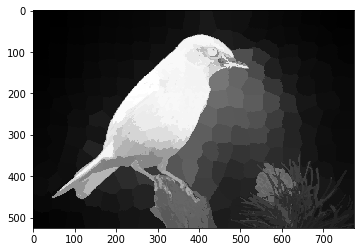

In [154]:
plt.imshow(dst,'gray')

参考：

[1]. https://blog.csdn.net/qq_26460507/article/details/57131147

[2]. https://blog.csdn.net/u013476464/article/details/30740169